In [1]:
import sys; sys.path.append('..')
import re
import os 
import pickle

from collections import defaultdict
from tqdm import tqdm

from datasets import load_dataset
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
from transformers import RobertaPreLayerNormForMaskedLM, AutoConfig

from hydra import compose, initialize
from hydra.core.config_store import ConfigStore
from src.utils.data import DatasetPreprocessor 
from src.config import BabyLMConfig
from src.tokenizer import load_tokenizer

/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/pos-merge/env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open("anisotropy_results.pkl", "rb") as f:
    anisotropy_results = pickle.load(f)

### Data utils and helper functions

In [3]:
def base_collate_fn(_samples):
    joined_batch = defaultdict(list)
    for sample in _samples:
        for key, val in sample.items():
            joined_batch[key].append(torch.tensor(val))

    batch = {}

    for key, val in joined_batch.items():
        batch[key] = torch.stack(val)

    return batch

In [4]:
class AnisotropyComputation: 
    def __init__(
        self,
        num_layers=8,
        layer_name_template=re.compile("roberta_prelayernorm.encoder.layer.(\d+).output$")
    ):
        self.num_layers = num_layers
        self.layer_name_template = layer_name_template

        self.cosine_sims = defaultdict(list)
    
    def get_fw_hook(self, module_name):
        def _forward_hook(module, _, module_out):
            # compute the cosine similarity between two random vectors in module_output
            # between first and second element of batch

            if isinstance(module_out, tuple):
                # The opt model returns a tuple where the first index is the hidden states output
                module_out = module_out[0]

            indices = torch.randint(0, 128, (2,))

            selected_vectors = torch.stack([module_out[i, index] for i, index in enumerate(indices)])
            cosine_sim = F.cosine_similarity(selected_vectors[0].unsqueeze(0), selected_vectors[1].unsqueeze(0))

            self.cosine_sims[module_name].append(cosine_sim.item())
       
        return _forward_hook

    def setup_hooks(self, model):
        for name, module in model.named_modules():
            if self.layer_name_template.match(name):
                module.register_forward_hook(self.get_fw_hook(name))


In [5]:
repo_path = "/home/rd654/pos-merge/models/pos_merge-roberta_pre_layer_norm-model"
model_path = f"{repo_path}/lm_model"

In [6]:
#  NOTE: Setting up config in order to load in dataset 

cs = ConfigStore.instance()
cs.store(name="base_config", node=BabyLMConfig)
with initialize(version_base=None, config_path="../conf",):
    cfg = compose(
        config_name="config",
        overrides=[
            "experiment.name=baseline_clean",
            "experiment.group=anisotropy",
            "dataset=uncleaned_strict_small_gold",
            "experiment.offline_run=True",
        ])

dataset = load_dataset(
    cfg.dataset.name,
    cfg.dataset.subconfig,
)  # type: ignore
tokenizer = load_tokenizer(cfg)
data_preprocessor = DatasetPreprocessor(cfg, tokenizer)
eval_dataset = dataset["validation"].map(
    data_preprocessor,
    batched=True,
    num_proc=64,
    remove_columns=dataset["validation"].column_names,
    load_from_cache_file=False,
)

Map (num_proc=64): 100%|██████████| 985958/985958 [00:12<00:00, 76147.21 examples/s] 
/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/pos-merge/env/lib/python3.9/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [7]:
import subprocess 

def parse_git_logs(branch_name):
    # Prepare the git log command to get commit hashes and messages
    command = f"git -C {repo_path} log origin/{branch_name} --pretty=format:'%H %s'"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    
    # Check for errors
    if result.stderr:
        print("Error:", result.stderr)
        return {}
    
    # Split the output into lines
    lines = result.stdout.split('\n')
    
    # Create a dictionary to hold step number and commit hash
    commits_dict = {}
    
    # Iterate over each line and parse the commit hash and step
    for line in lines:
        parts = line.split(' ', 1)
        if len(parts) < 2:
            continue
        
        commit_hash = parts[0]
        commit_message = parts[1]
        
        # Look for the step number in the commit message
        if 'step' in commit_message:
            step_number = commit_message.split('step')[1].split()[0]  # Assume 'step' is followed by the step number
            commits_dict[step_number] = commit_hash
           
    return commits_dict

def checkout_branch(branch_name):
    command = f"git -C {repo_path} checkout origin/{branch_name}"
    subprocess.run(command, shell=True, capture_output=True, text=True)

def checkout_commit(commit_id):
    command = f"git -C {repo_path} checkout {commit_id}"
    subprocess.run(command, shell=True, capture_output=True, text=True)


#### Baseline Anisotropy Computation 

Note that I don't think these values are a valid point of comparison with the models we train 
using the POS Smoothing method because they are larger models with larger hidden embedding sizes. 

In [8]:
from transformers import AutoTokenizer, OPTForCausalLM, T5ForConditionalGeneration, RobertaForMaskedLM

raw_val_dataset = dataset["validation"]

def compute_pretrained_baseline_anisotropy(model_path):
    """
    Computes the anisotropy for the pretrained OPT, RoBERTa, and T5 models 
    """
 
    if "roberta" in model_path: 
        model_cls = RobertaForMaskedLM
    elif "t5" in model_path:
        model_cls = T5ForConditionalGeneration
    else:
        model_cls = OPTForCausalLM

    model = model_cls.from_pretrained(model_path,)
    # _model.config._name_or_path = None # forcibly removing the name or path to require reinitialization
    # model = model_cls(_model.config)

    _tokenizer = AutoTokenizer.from_pretrained(model_path)
   
    _data_preprocessor = DatasetPreprocessor(cfg, _tokenizer)
    _eval_dataset = dataset["validation"].map(
        _data_preprocessor,
        batched=True,
        num_proc=64,
        remove_columns=dataset["validation"].column_names,
        load_from_cache_file=False,
    )

    model.cuda()
    model.eval()

    if "roberta" in model_path:
        anisotropy_computation = AnisotropyComputation(layer_name_template=re.compile("roberta.encoder.layer.(\d+).attention.output.dense$"))
        # anisotropy_computation = AnisotropyComputation(layer_name_template=re.compile("roberta.encoder.layer.(\d+).output$"))
    elif "t5" in model_path: 
        anisotropy_computation = AnisotropyComputation(layer_name_template=re.compile("encoder.block.(\d+).layer.1$"))
    else:
        anisotropy_computation = AnisotropyComputation(layer_name_template=re.compile("model.decoder.layers.(\d+)$"))

    anisotropy_computation.setup_hooks(model)

    _eval_dataset = _eval_dataset.shuffle(seed=42)
    eval_dataloader = DataLoader(
        _eval_dataset,
        batch_size = 2,
        collate_fn=base_collate_fn,
    )

    # convert the 
    for idx, _batch in tqdm(enumerate(eval_dataloader)):
        if idx > 100:
            break 

        if "t5" in model_path:
            batch = {
                "decoder_input_ids": _batch['input_ids'].to("cuda"), 
                "input_ids":  _batch['input_ids'].to("cuda"),
                "attention_mask":  _batch['attention_mask'].to("cuda"),
            }
        else:
            batch = {
                "input_ids": _batch['input_ids'].to("cuda"),
                "attention_mask":  _batch['attention_mask'].to("cuda"),
            }

        model(**batch)
        
    return anisotropy_computation.cosine_sims


roberta_baseline_model_path = "babylm/roberta-base-strict-small-2023"
t5_baseline_model_path = "babylm/t5-base-strict-small-2023"
opt_baseline_model_path = "babylm/opt-125m-strict-small-2023"
roberta_anisotropy = compute_pretrained_baseline_anisotropy(roberta_baseline_model_path)
t5_anisotropy = compute_pretrained_baseline_anisotropy(t5_baseline_model_path)
opt_anisotropy = compute_pretrained_baseline_anisotropy(opt_baseline_model_path)

Map (num_proc=64):  65%|██████▍   | 636496/985958 [00:07<00:03, 114004.97 examples/s]Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (623 > 512). Running this sequence through the model will result in indexing errors
Map (num_proc=64):  89%|████████▉ | 879287/985958 [00:09<00:01, 95388.13 examples/s]Token indices sequence length is longer than the specified maximum sequence length for this model (796 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (718 > 512). Running this sequence through the model will result in indexing errors
Map (num_proc=64): 100%|██████████| 985958/985958 [00:14<00:00, 70348.07 examples/s]


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
avg_roberta_anisotropy = 0.0
for layer_name, cosine_sims in roberta_anisotropy.items():
    avg_roberta_anisotropy += sum(cosine_sims) / len(cosine_sims)
    # print(f"layer_name: {layer_name} -- cosine_sims: {sum(cosine_sims) / len(cosine_sims)}")

print(f"RoBERTa Anisotropy: {avg_roberta_anisotropy / len(roberta_anisotropy)}")

avg_t5_anisotropy = 0.0
for layer_name, cosine_sims in t5_anisotropy.items():
    avg_t5_anisotropy += sum(cosine_sims) / len(cosine_sims)
    # print(f"layer_name: {layer_name} -- cosine_sims: {sum(cosine_sims) / len(cosine_sims)}")

print(f"T5 Anisotropy: {avg_t5_anisotropy / len(t5_anisotropy)}")

avg_opt_anisotropy = 0.0
for layer_name, cosine_sims in opt_anisotropy.items():
    avg_opt_anisotropy += sum(cosine_sims) / len(cosine_sims)
    # print(f"layer_name: {layer_name} -- cosine_sims: {sum(cosine_sims) / len(cosine_sims)}")

print(f"OPT Anisotropy: {avg_opt_anisotropy / len(opt_anisotropy)}")

NameError: name 'roberta_anisotropy' is not defined

#### Standard model Anisotropy computation 

Anisotropy computation for the models we train on the small RoBERTa model. 

In [ ]:
output_file = "anisotropy_results.pkl"

branch_names = [
    "baseline_unclean",
    "tied_baseline_unclean_05_ls",
    "tied_baseline_unclean_08_ls",
    "tied_cosine_linear_02_10",
    "tied_cosine_linear_05_10", 
    "tied_cosine_linear_08_10",
    "tied_cosine_linear_05_05",
    "tied_cosine_linear_08_08",
]

jsd_branch_names = [
    "tied_jsd_linear_02_10",
    "tied_jsd_linear_05_10", 
    "tied_jsd_linear_08_10",
    "tied_jsd_linear_05_05",
    "tied_jsd_linear_08_08",
]


def compute_initial_anisotropy():
    """
    Computes the anisotropy of a randomly initialized model
    """
    # This is just the commit id for step 200k of the tied baseline unclean model 
    # we'll use this commit to just load the model and then reinitialize the weights
    commit_id = "04ad593683da363ea197f40dccad465c8756175b"
    checkout_commit(commit_id)

    _model = RobertaPreLayerNormForMaskedLM.from_pretrained(model_path)
    _model.config._name_or_path = None # forcibly removing the name or path to require reinitialization
    model = RobertaPreLayerNormForMaskedLM(_model.config)

    model.cuda()
    model.eval()

    anisotropy_computation = AnisotropyComputation()
    anisotropy_computation.setup_hooks(model)

    _eval_dataset = eval_dataset.shuffle(seed=42)
    eval_dataloader = DataLoader(
        _eval_dataset,
        batch_size = 2,
        collate_fn=base_collate_fn,
    )

    for idx, _batch in tqdm(enumerate(eval_dataloader)):
        if idx > 1_000:
            break 

        batch  = {
            "input_ids": _batch["input_ids"].to("cuda"),
            "attention_mask": _batch["attention_mask"].to("cuda"),
        }
        model(**batch)
    
    return anisotropy_computation.cosine_sims


def compute_anisotropy_learning_dynamics(branch_names=branch_names, output_file=output_file, only_last_checkpoint=False):
    """ 
    Computes the anisotropy learning dynamics for the different branches and checkpoints
    """

    if os.path.exists(output_file):

        print("Loading in existing anisotropy results")
        with open(output_file, "rb") as f:
            anisotropy_results = pickle.load(f)
        
        return anisotropy_results

    anisotropy_results = dict()

    for branch_name in branch_names:
        print(f"Processing Batch Name: {branch_name}")

        checkout_branch(branch_name)
        branch_commit_steps = parse_git_logs(branch_name)

        anisotropy_results[branch_name] = dict()

        for checkpoint_step, commit_id in branch_commit_steps.items():

            print(f"Processing Checkpoint Step: {checkpoint_step}")
            checkout_commit(commit_id)

            model = RobertaPreLayerNormForMaskedLM.from_pretrained(model_path)
            model.cuda()
            model.eval()

            anisotropy_computation = AnisotropyComputation()
            anisotropy_computation.setup_hooks(model)

            _eval_dataset = eval_dataset.shuffle(seed=42)
            eval_dataloader = DataLoader(
                _eval_dataset,
                batch_size = 2,
                collate_fn=base_collate_fn,
            )

            for idx, _batch in tqdm(enumerate(eval_dataloader)):
                if idx > 1_000:
                    break 

                batch  = {
                    "input_ids": _batch["input_ids"].to("cuda"),
                    "attention_mask": _batch["attention_mask"].to("cuda"),
                }
                model(**batch)

            print(f"Branch: {branch_name}, Step: {checkpoint_step}")
            print("Cosine Similarity:")
            for layer_name, cosine_sims in anisotropy_computation.cosine_sims.items():
                print(f"{layer_name}: {sum(cosine_sims) / len(cosine_sims)}")
            print("\n\n")

            anisotropy_results[branch_name][checkpoint_step] = anisotropy_computation.cosine_sims

            if only_last_checkpoint:
                break

    # save out the results
    with open(output_file, "wb") as f:
        pickle.dump(anisotropy_results, f) 
    
    return anisotropy_results

In [ ]:
_zero_step_anisotropy_results = compute_initial_anisotropy()
zero_step_anisotropy_results = dict()
for layer_name, cosine_sims in _zero_step_anisotropy_results.items():
    print(f"{layer_name}: {sum(cosine_sims) / len(cosine_sims)}")
    zero_step_anisotropy_results[layer_name] = sum(cosine_sims) / len(cosine_sims)

OSError: Can't load the configuration of '/home/rd654/pos-merge/models/pos_merge-roberta_pre_layer_norm-model/lm_model'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure '/home/rd654/pos-merge/models/pos_merge-roberta_pre_layer_norm-model/lm_model' is the correct path to a directory containing a config.json file

In [ ]:
anisotropy_results = compute_anisotropy_learning_dynamics()

Loading in existing anisotropy results


#### Anisotropy Learning Dynamics
Plotting out learning dynamics of different models over the course of training 

In [11]:
# Read in results
with open('anisotropy_results.pkl', "rb") as f:
    anisotropy_results = pickle.load(f)
with open('zero_step_anisotropy_results.pkl', 'rb') as f:
    zero_step_anisotropy_results = pickle.load(f)

In [12]:
anisotropy_plotting = defaultdict(lambda: defaultdict(list))

for model_name, model_anisotropy_results in anisotropy_results.items():
    print(f"Model: {model_name}")

    # sort model_anisotropy_results by step
    model_anisotropy_results = dict(sorted(model_anisotropy_results.items(), key=lambda x: int(x[0])))

    for layer_name, initial_anisotropy in zero_step_anisotropy_results.items():
        anisotropy_plotting[model_name][layer_name].append(initial_anisotropy)

    for step, checkpoint_anisotropy_results in model_anisotropy_results.items():
        for layer_name, layer_cosines in checkpoint_anisotropy_results.items():
            anisotropy_plotting[model_name][layer_name].append(
                sum(layer_cosines) / len(layer_cosines)
            )

Model: baseline_unclean
Model: tied_baseline_unclean_05_ls
Model: tied_baseline_unclean_08_ls
Model: tied_cosine_linear_02_10
Model: tied_cosine_linear_05_10
Model: tied_cosine_linear_08_10
Model: tied_cosine_linear_05_05
Model: tied_cosine_linear_08_08


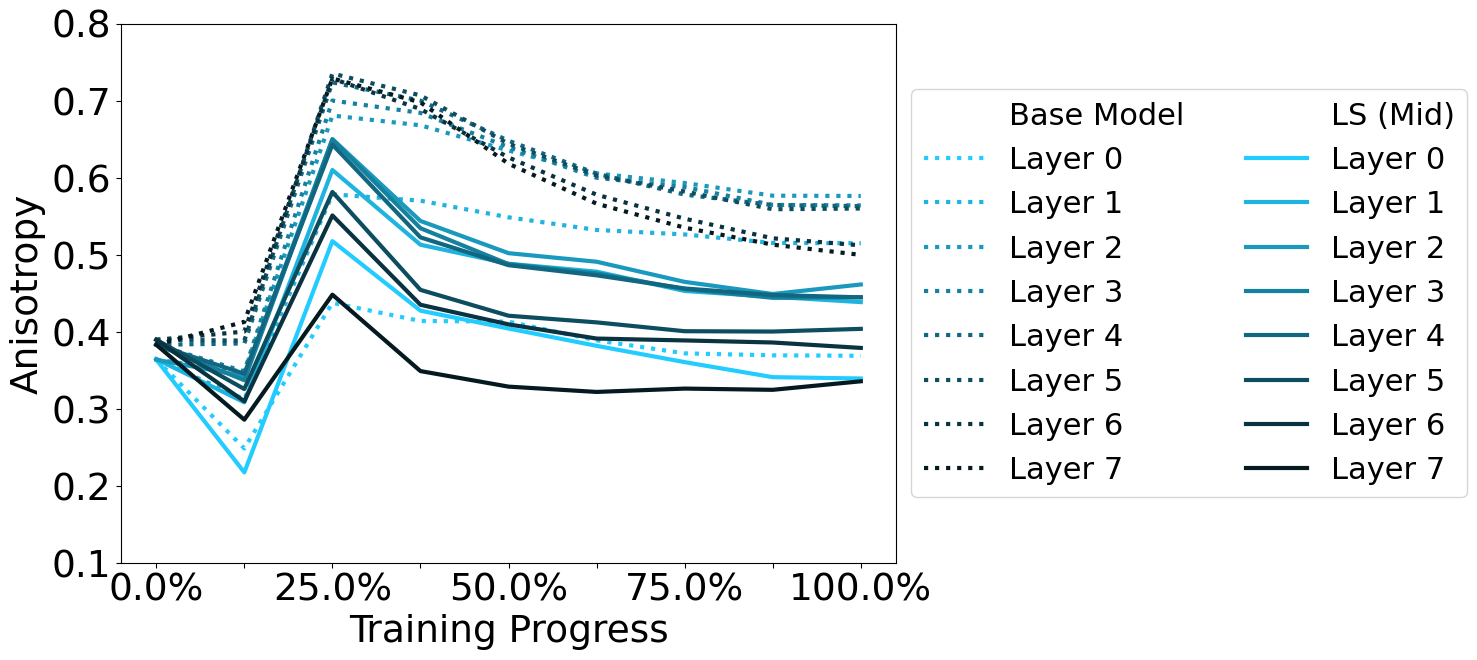

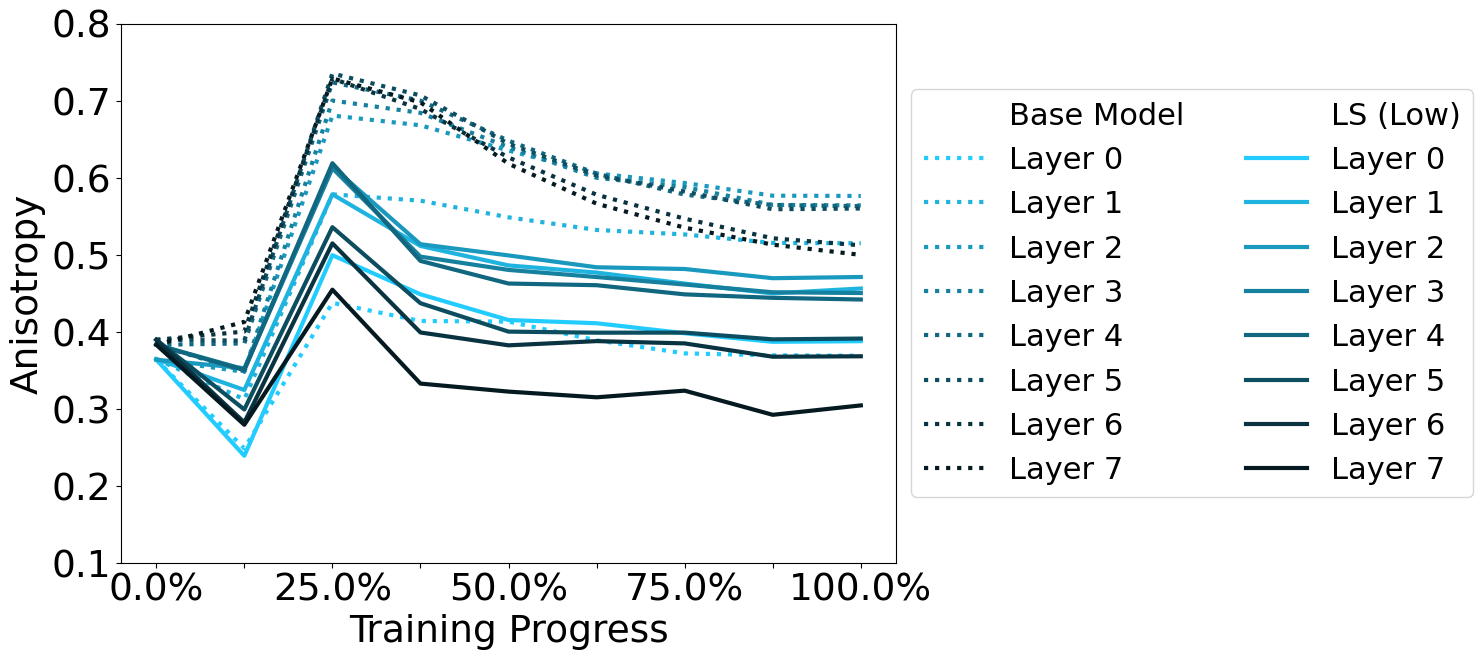

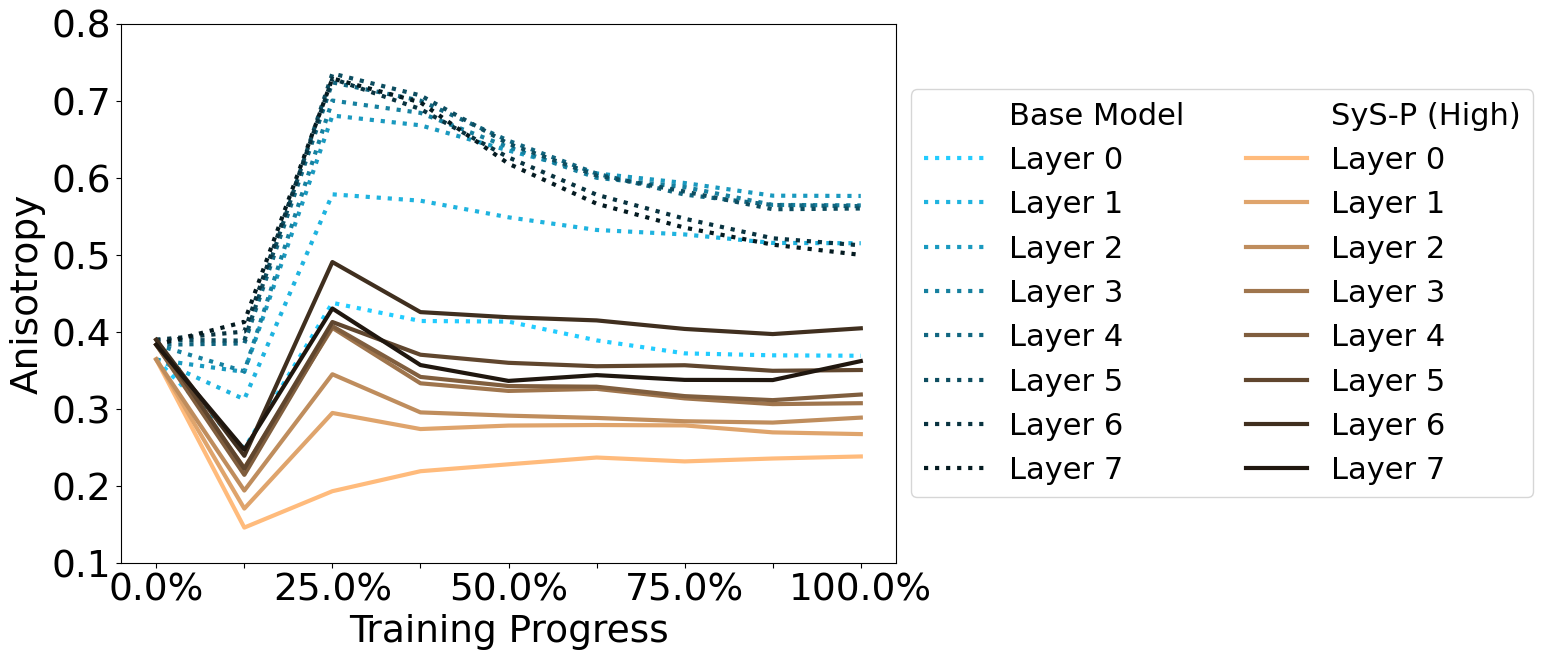

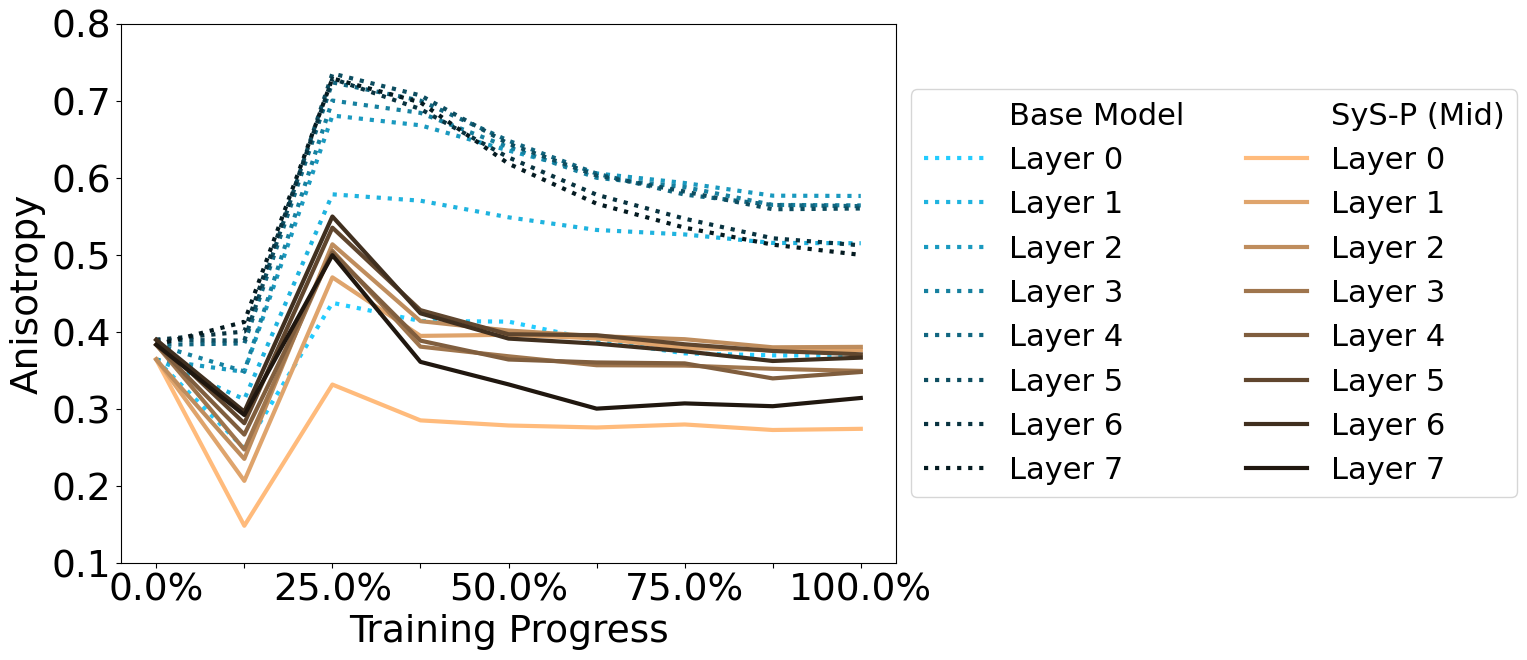

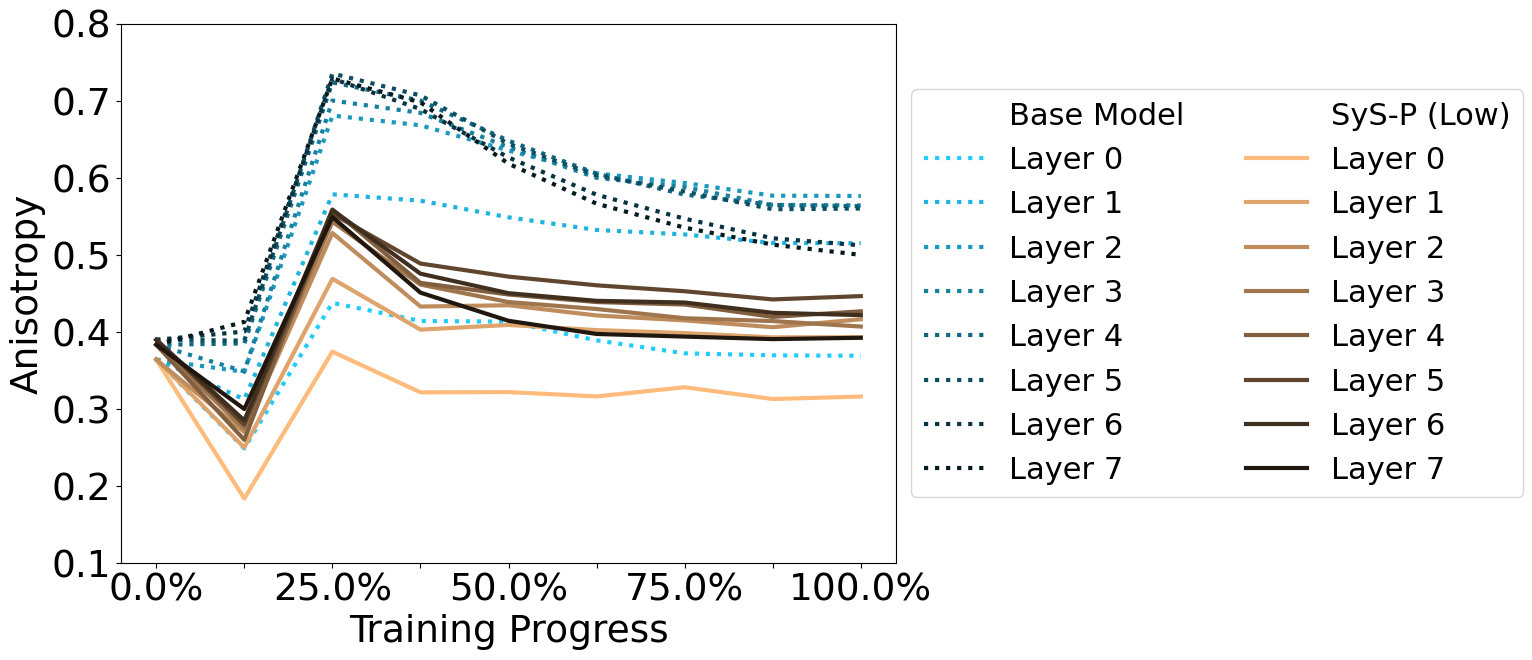

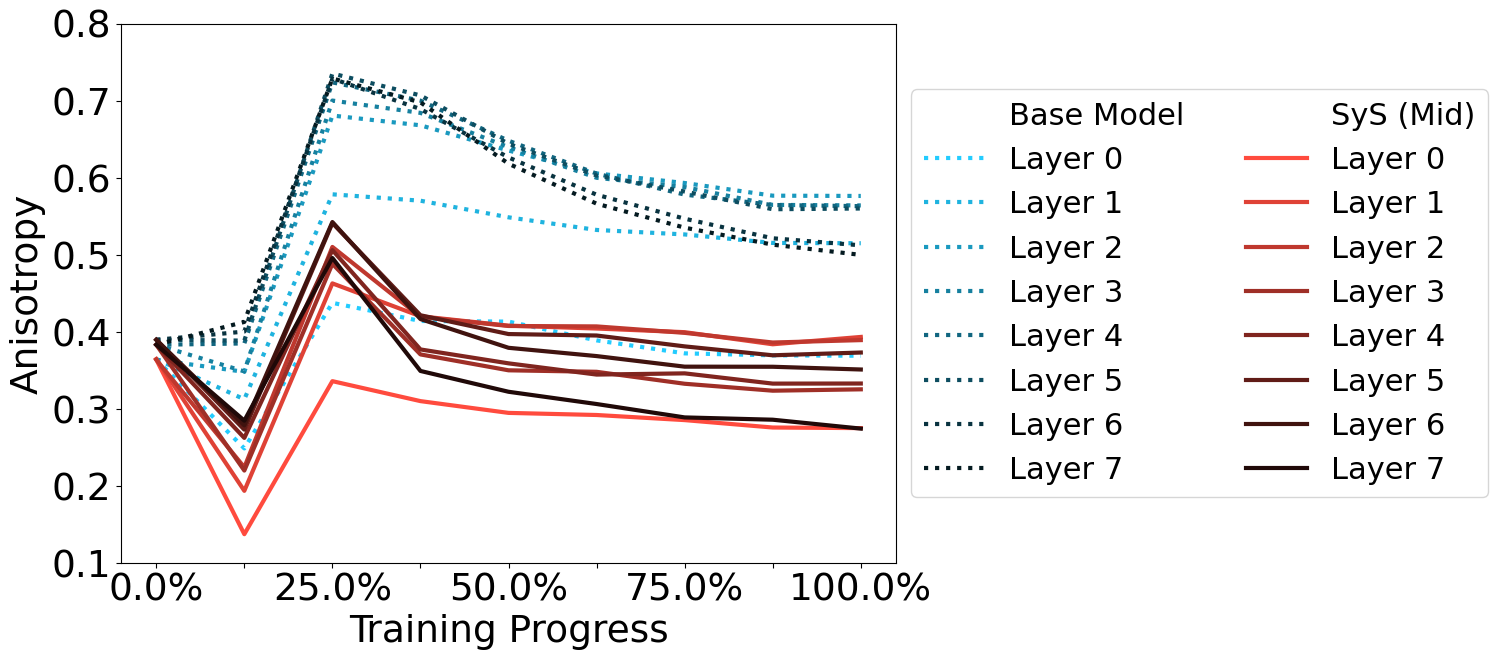

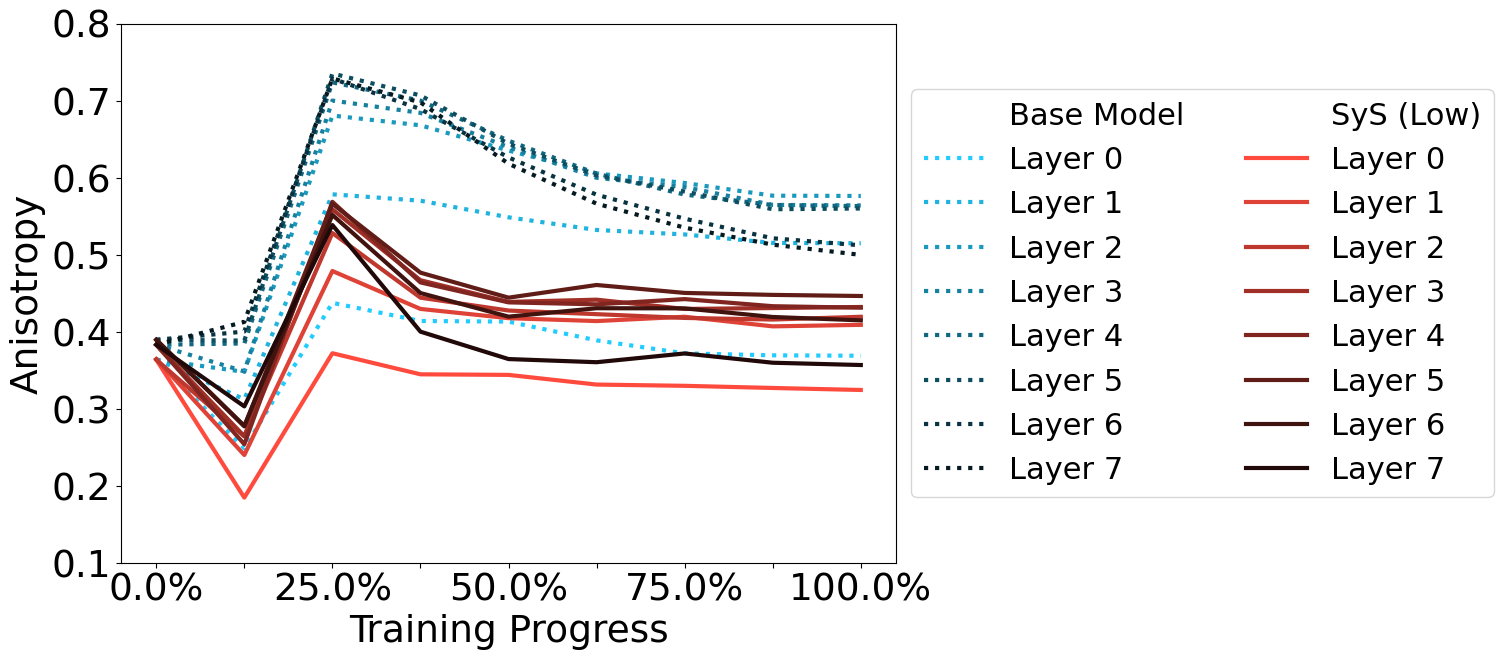

In [31]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import colorsys
import numpy as np

plt.rcParams.update({'font.size': 27})
plt.rcParams.update({'legend.fontsize': 22})
plt.rcParams['lines.linewidth'] = 3
checkpoint_steps = [i*25_000 for i in range(9)]

baseline_model = 'baseline_unclean'

# Define line styles for different model names
line_styles = {
    'baseline_unclean': ':',
    'tied_baseline_unclean_05_ls': '-',
    'tied_baseline_unclean_08_ls': '--',
    'tied_cosine_linear_05_05': '-',
    'tied_cosine_linear_08_08': '--',
    'tied_cosine_linear_02_10': '-.',
    'tied_cosine_linear_05_10': '-',
    'tied_cosine_linear_08_10': '--',
}

line_colors = {
    'baseline_unclean': '#3E1E01',
    'tied_baseline_unclean_05_ls': '#23CCFF',
    'tied_baseline_unclean_08_ls': '#23CCFF',
    'tied_cosine_linear_05_05': '#EB4539',
    'tied_cosine_linear_08_08': '#EB4539',
    'tied_cosine_linear_02_10': '#FDBA7B',
    'tied_cosine_linear_05_10': '#FDBA7B',
    'tied_cosine_linear_08_10': '#FDBA7B',
}

ordered_model_names = [ 
    'baseline_unclean',
    'tied_baseline_unclean_08_ls',
    'tied_baseline_unclean_05_ls',
    'tied_cosine_linear_08_08',
    'tied_cosine_linear_05_05',
    'tied_cosine_linear_08_10',
    'tied_cosine_linear_05_10',
    'tied_cosine_linear_02_10',
]

model_name_conversion = { 
    'baseline_unclean': 'Base Model',
    'tied_baseline_unclean_05_ls': 'LS (Mid)',
    'tied_baseline_unclean_08_ls': 'LS (Low)',
    'tied_cosine_linear_02_10': 'SyS-P (High)',
    'tied_cosine_linear_05_10': 'SyS-P (Mid)',
    'tied_cosine_linear_08_10': 'SyS-P (Low)',
    'tied_cosine_linear_05_05': 'SyS (Mid)',
    'tied_cosine_linear_08_08': 'SyS (Low)',
}

def create_heatmap_from_one_color(color, amount):
    """
    Create a heatmap of colors from a single color
    """
    colors = []
    for i in range(amount):
        hsv = list(colorsys.rgb_to_hsv(*mcolors.hex2color(color)))
        hsv[2] = 1 - i / amount
        rgb = mcolors.hsv_to_rgb(hsv)
        colors.append(rgb)
    return colors

# Specific models to compare
compare_models = [
    'tied_baseline_unclean_05_ls', 'tied_baseline_unclean_08_ls',
    'tied_cosine_linear_02_10', 'tied_cosine_linear_05_10', 
    'tied_cosine_linear_08_10', 'tied_cosine_linear_05_05', 
    'tied_cosine_linear_08_08'
]

# Loop over each specific model for individual plots
for model_name in compare_models:
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Plot baseline_unclean in each comparison
    if baseline_model in anisotropy_plotting:

        baselines = []

        for layer_index, (layer_name, layer_cosines) in enumerate(anisotropy_plotting[baseline_model].items()):
            color = create_heatmap_from_one_color('#23CCFF', len(anisotropy_plotting[baseline_model]))[layer_index]
            b, = ax.plot(checkpoint_steps, layer_cosines, label=f"Base Model - Layer: {layer_index}", linestyle=line_styles[baseline_model], color=color)
            baselines.append(b)

    # Plot the specific model being compared
    if model_name in anisotropy_plotting:

        model = []

        for layer_index, (layer_name, layer_cosines) in enumerate(anisotropy_plotting[model_name].items()):
            color = create_heatmap_from_one_color(line_colors[model_name], len(anisotropy_plotting[model_name]))[layer_index]
            m, = ax.plot(checkpoint_steps, layer_cosines, label=f"{model_name_conversion[model_name]} - Layer: {layer_index}", linestyle='-', color=color)
            model.append(m)

    dum1, = ax.plot([0], [0], marker='None', linestyle='None', label='dummy-tophead')
    dum2, = ax.plot([0], [0], marker='None', linestyle='None', label='dummy-empty')

    layers = [f'Layer {i}' for i in range(8)]
    leg = ax.legend([dum1] + baselines + [dum1] + model,
                     ['Base Model'] + layers + [model_name_conversion[model_name]] + layers,
                     loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
    # leg2 = ax.legend([dum1, dum2, dum1, dum2] + baselines + model,
    #                  ['Base Model', '', model_name_conversion[model_name], ''] + layers + layers,
    #                  loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
    # ax.add_artist(leg)
    


    # Adding labels and title
    plt.xlabel('Training Progress')
    plt.xticks(checkpoint_steps, [f'{i*12.5}%' if i%2==0 else '' for i in range(9)])
    plt.ylabel('Anisotropy')
    plt.ylim(0.1,0.8)
    # plt.title(f'Anisotropy Analysis - Baseline vs. Model: {model_name}')
    plt.show()


Averaging over all of the layers so that for each model at each checkpoint we just compute the average anisotropy 

Model: Base Model, Final Anisotropy: 0.5198899059217762
Model: LS (Low), Final Anisotropy: 0.4088166507868876
Model: LS (Mid), Final Anisotropy: 0.40585803182607644
Model: SyS (Low), Final Anisotropy: 0.4042479415216225
Model: SyS (Mid), Final Anisotropy: 0.3391458192434786
Model: SyS-P (Low), Final Anisotropy: 0.4022613718868645
Model: SyS-P (Mid), Final Anisotropy: 0.34728628646698273
Model: SyS-P (High), Final Anisotropy: 0.3169563456709342


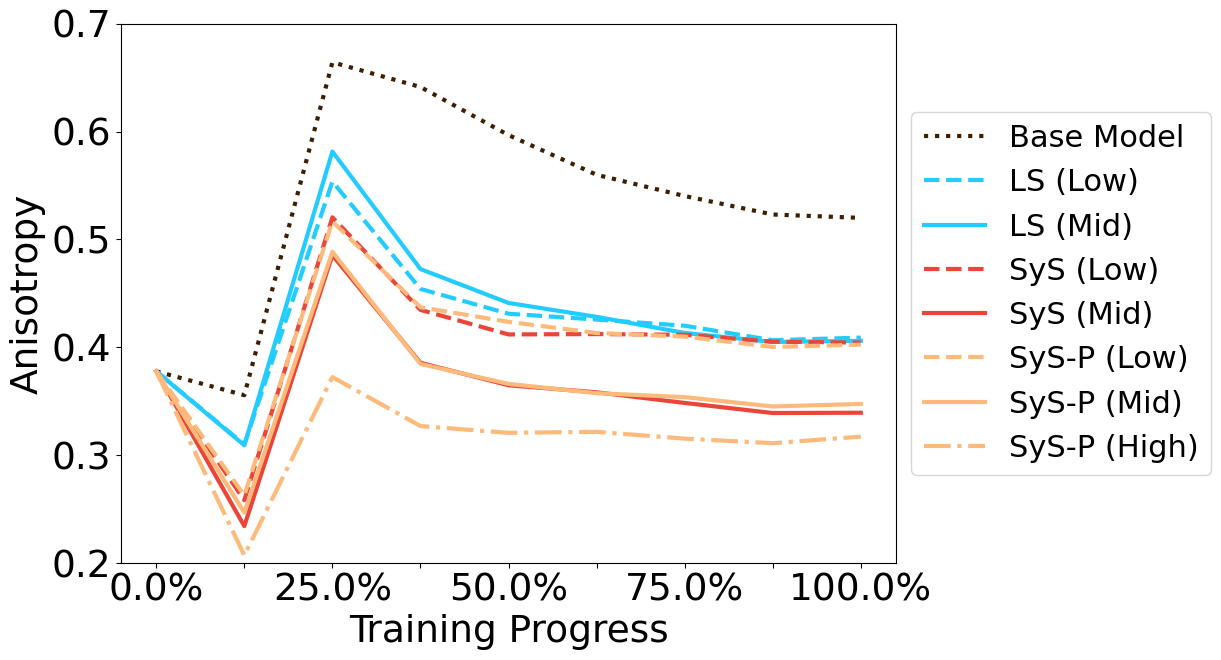

In [32]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 7))

num_layers = 8

average_model_anisotropies = dict()

# move tied_cosine_linear_05_05

# Loop over each specific model for individual plots
for model_name in ordered_model_names: 
    model_anisotropy = anisotropy_plotting[model_name]
 
    average_anisotropy = np.zeros(len(checkpoint_steps))
    # average over all fo the models 
    for idx, layer_cosines in enumerate(model_anisotropy.values()):
        average_anisotropy += np.array(layer_cosines)
    
    average_anisotropy /= num_layers

    average_model_anisotropies[model_name] = average_anisotropy

    # Plot the specific model being compared
    plt.plot(checkpoint_steps, average_anisotropy, label=f"{model_name_conversion[model_name]}",linestyle=line_styles[model_name], color=line_colors[model_name])

    # print out the final anisotropy
    print(f"Model: {model_name_conversion[model_name]}, Final Anisotropy: {average_anisotropy[-1]}")

# Adding labels and title
plt.xlabel('Training Progress')
plt.ylabel('Anisotropy')
plt.ylim(0.2,0.7)
# Make x-axis percentages instead of steps, for every other step
plt.xticks(checkpoint_steps, [f'{i*12.5}%' if i%2==0 else '' for i in range(9)])

# plt.title(f'Anisotropy Analysis')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [21]:
# NOTE: Computing the JSD anisotropy results
jsd_anisotropy_results = compute_anisotropy_learning_dynamics(branch_names=jsd_branch_names, output_file="jsd_anisotropy_results.pkl", only_last_checkpoint=True)

NameError: name 'compute_anisotropy_learning_dynamics' is not defined

In [22]:
# Average the anisotropy results
for model_name, model_anisotropy_results in jsd_anisotropy_results.items():
    # sort model_anisotropy_results by step
    model_anisotropy_results = model_anisotropy_results['200000']

    average_anisotropy = 0.0

    for layer_name, layer_anisotropy_results in model_anisotropy_results.items():
        average_anisotropy += sum(layer_anisotropy_results) / len(layer_anisotropy_results)

    print(f"Model: {model_name}, Average Anisotropy: {average_anisotropy / len(model_anisotropy_results)}")


NameError: name 'jsd_anisotropy_results' is not defined

### Correlation between anisotropy and frequency bias 

Reading in the associated learning dynamics for the frequency bias 

In [23]:
# load in the bias_results.csv
import pandas as pd

bias_results = pd.read_csv("bias_results.csv")
model_biases = { 
    model_name: bias_results[f'{model_name} - eval/blimp_bias_total_increase'].tolist() for model_name in average_model_anisotropies.keys() if model_name != 'baseline_unclean'
}
model_biases['baseline_unclean'] = bias_results[f'tied_baseline_unclean - eval/blimp_bias_total_increase'].tolist()


#### Linear and Polynomial Regression Analysis

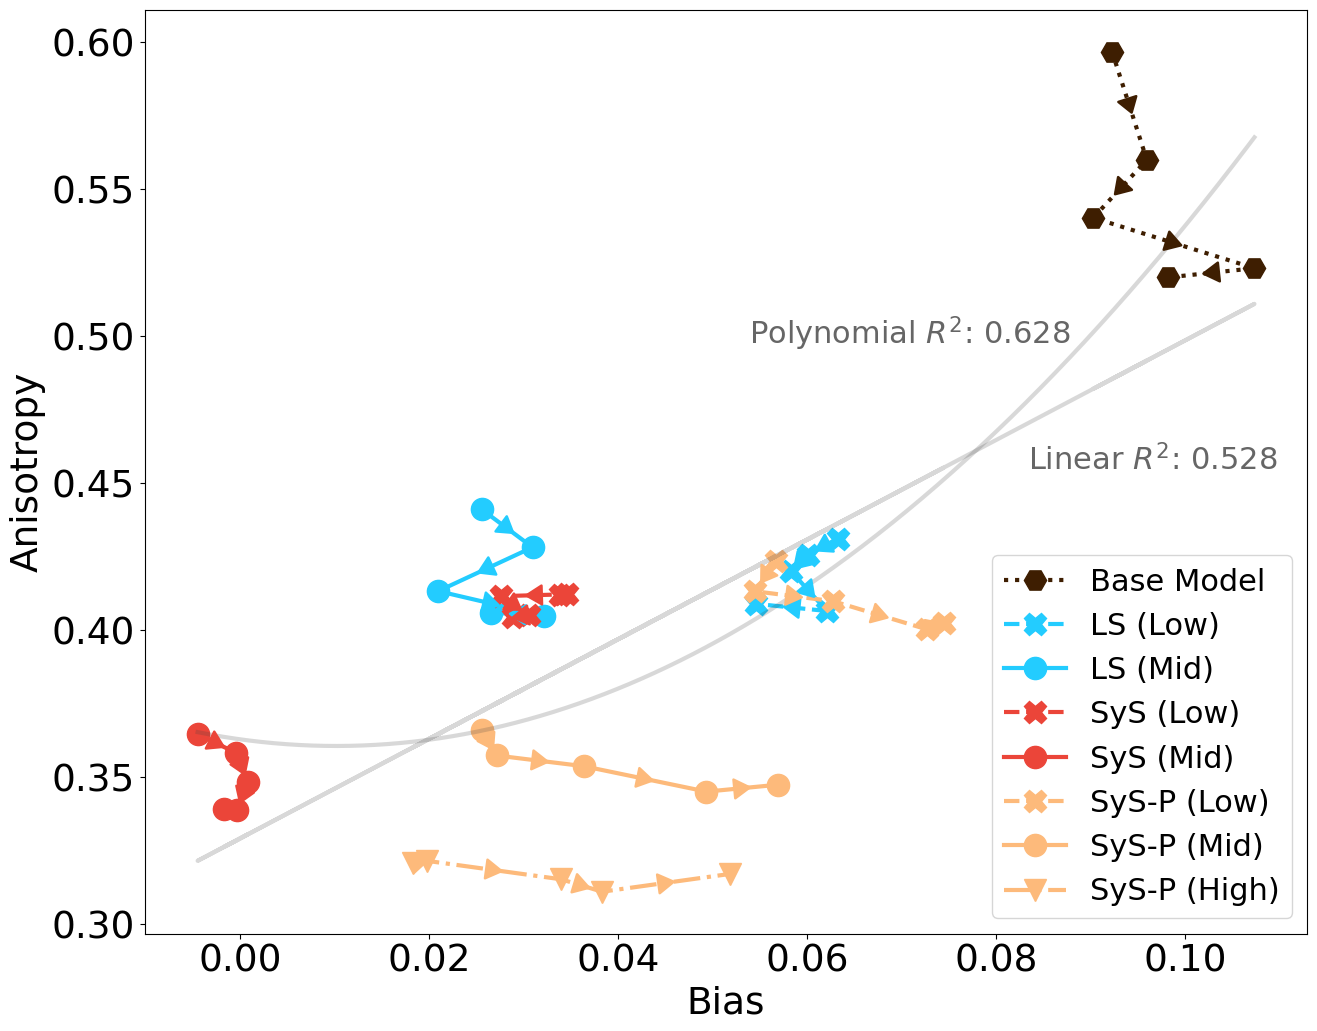

In [40]:
# plot the correlation between the bias and the anisotropy

from matplotlib.patches import ArrowStyle

plot, ax = plt.subplots(figsize=(15, 12))

X_biases =  []
Y_anisotropy = []

marker_styles = {
    'baseline_unclean': 'H',
    'tied_baseline_unclean_05_ls': 'o',
    'tied_baseline_unclean_08_ls': 'X',
    'tied_cosine_linear_05_05': 'o',
    'tied_cosine_linear_08_08': 'X',
    'tied_cosine_linear_02_10': 'v',
    'tied_cosine_linear_05_10': 'o',
    'tied_cosine_linear_08_10': 'X',
}

for model_name in ordered_model_names:
    if model_name == 'tied_baseline_unclean':
        model_name = 'baseline_unclean'

    i = 4

    ax.plot(model_biases[model_name][i:], average_model_anisotropies[model_name][i:], label=model_name_conversion[model_name], color=line_colors[model_name],  marker=marker_styles[model_name], markersize=16, linestyle=line_styles[model_name])
    X_biases.extend(model_biases[model_name][i:])
    Y_anisotropy.extend(average_model_anisotropies[model_name][i:])
    # Add arrow head pointing right in the middle of each line segment
    for j in range(len(model_biases[model_name][i:])-1):
        x = model_biases[model_name][i:][j]
        y = average_model_anisotropies[model_name][i:][j]
        dx = model_biases[model_name][i:][j+1] - x
        dy = average_model_anisotropies[model_name][i:][j+1] - y
        distance = np.sqrt((3*dx)**2 + dy**2) * 300
        dx2 = dx / distance
        dy2 = dy / distance
        #plt.arrow(x, y, dx, dy, head_width=0.0028, head_length=0.003, fc=line_colors[model_name], ec=line_colors[model_name], alpha=1, length_includes_head=True, overhang=0.4, ls='', width=0)
        ax.annotate('', xytext=(x+dx/2-dx2, y+dy/2-dy2), xy=(x+dx/2+dx2, y+dy/2+dy2), arrowprops=dict(arrowstyle=ArrowStyle('wedge', tail_width=0.5), color=line_colors[model_name], lw=1.8))


# compute the R2 value of X_biases and Y_anisotropy - show as red line on plot 

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline


X_biases = np.array(X_biases).reshape(-1, 1)
Y_anisotropy = np.array(Y_anisotropy).reshape(-1, 1)

c = '#00A606'
c = '#404040'

# LINEAR REGRESSION
reg = LinearRegression().fit(X_biases, Y_anisotropy)
linear_r2 = r2_score(Y_anisotropy, reg.predict(X_biases))
plt.plot(X_biases, reg.predict(X_biases), color=c, alpha=0.2)

# POLYNOMIAL Regression
poly_model = make_pipeline(PolynomialFeatures(2), LinearRegression())
poly_model.fit(X_biases, Y_anisotropy)
poly_r2 = r2_score(Y_anisotropy, poly_model.predict(X_biases))

X_grid = np.linspace(X_biases.min(), X_biases.max(), 500).reshape(-1, 1)
Y_pred = poly_model.predict(X_grid)

# Plot polynomial regression line
ax.plot(X_grid, Y_pred, color=c, alpha=0.2)


linear_r2_label = f"Linear $R^2$: {linear_r2:.3f}"  # Replace `r2_score` with the actual R2 score value
ax.text(0.76, 0.53, linear_r2_label, transform=plt.gca().transAxes, ha='left', va='top', color=c, fontsize=22, alpha=0.8)
poly_r2_label = f"Polynomial $R^2$: {poly_r2:.3f}"  # Replace `r2_score` with the actual R2 score value
ax.text(0.52, 0.67, poly_r2_label, transform=plt.gca().transAxes, ha='left', va='top', color=c, fontsize=22, alpha=0.8)

# plt.text(0.05, 0.88, poly_r2_label, transform=plt.gca().transAxes, ha='left', va='top', color='black',
#          bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'), fontsize=10)
# plt.text(0.05, 0.88, poly_r2_label, transform=plt.gca().transAxes, ha='left', va='top', color='black',
#          bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'), fontsize=10)


# Adding labels and title
plt.xlabel('Bias')
plt.ylabel('Anisotropy')
# plt.title('Bias vs. Anisotropy')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))

# Swap x and y
#plt.gca().invert_xaxis()

plt.show()

#### Correlation Analysis

In [ ]:
# correlate how the anisotropy changes with the bias
from scipy.stats import pearsonr, spearmanr, kendalltau

correlations = dict()
for model_name in model_biases.keys():
    print(f"Model Name: {model_name}")
    print(f"\t Pearson Correlation: {pearsonr(model_biases[model_name], average_model_anisotropies[model_name])}")
    print(f"\t Spearman Correlation: {spearmanr(model_biases[model_name], average_model_anisotropies[model_name])}")
    print(f"\t Kendall Correlation: {kendalltau(model_biases[model_name], average_model_anisotropies[model_name])}")

Model Name: tied_baseline_unclean_05_ls
	 Pearson Correlation: PearsonRResult(statistic=0.2695786052600643, pvalue=0.4829994928364993)
	 Spearman Correlation: SignificanceResult(statistic=0.25, pvalue=0.5164895523012263)
	 Kendall Correlation: SignificanceResult(statistic=0.16666666666666666, pvalue=0.612202380952381)
Model Name: tied_baseline_unclean_08_ls
	 Pearson Correlation: PearsonRResult(statistic=0.3406160474159801, pvalue=0.3697369501171062)
	 Spearman Correlation: SignificanceResult(statistic=0.48333333333333334, pvalue=0.18746985521554207)
	 Kendall Correlation: SignificanceResult(statistic=0.3333333333333333, pvalue=0.25951829805996474)
Model Name: tied_cosine_linear_05_05
	 Pearson Correlation: PearsonRResult(statistic=-0.1643364690360834, pvalue=0.6726596595208709)
	 Spearman Correlation: SignificanceResult(statistic=-0.4666666666666666, pvalue=0.20538635110581185)
	 Kendall Correlation: SignificanceResult(statistic=-0.3333333333333333, pvalue=0.25951829805996474)
Model N

In [ ]:
from scipy.stats import spearmanr, kendalltau

# Calculate pearson correlation coefficient
pearson_corr, _ = pearsonr(X_biases.flatten(), Y_anisotropy.flatten())

# Calculate Spearman's and Kendall's correlation coefficientsn
spearman_corr, _ = spearmanr(X_biases.flatten(), Y_anisotropy.flatten())
kendall_corr, _ = kendalltau(X_biases.flatten(), Y_anisotropy.flatten())

print(f"Pearson Correlation: {pearson_corr}")
print(f"Spearman Correlation: {spearman_corr}")
print(f"Kendall’s Tau: {kendall_corr}")

Pearson Correlation: 0.7263826935046362
Spearman Correlation: 0.5416510318949344
Kendall’s Tau: 0.3820512820512821


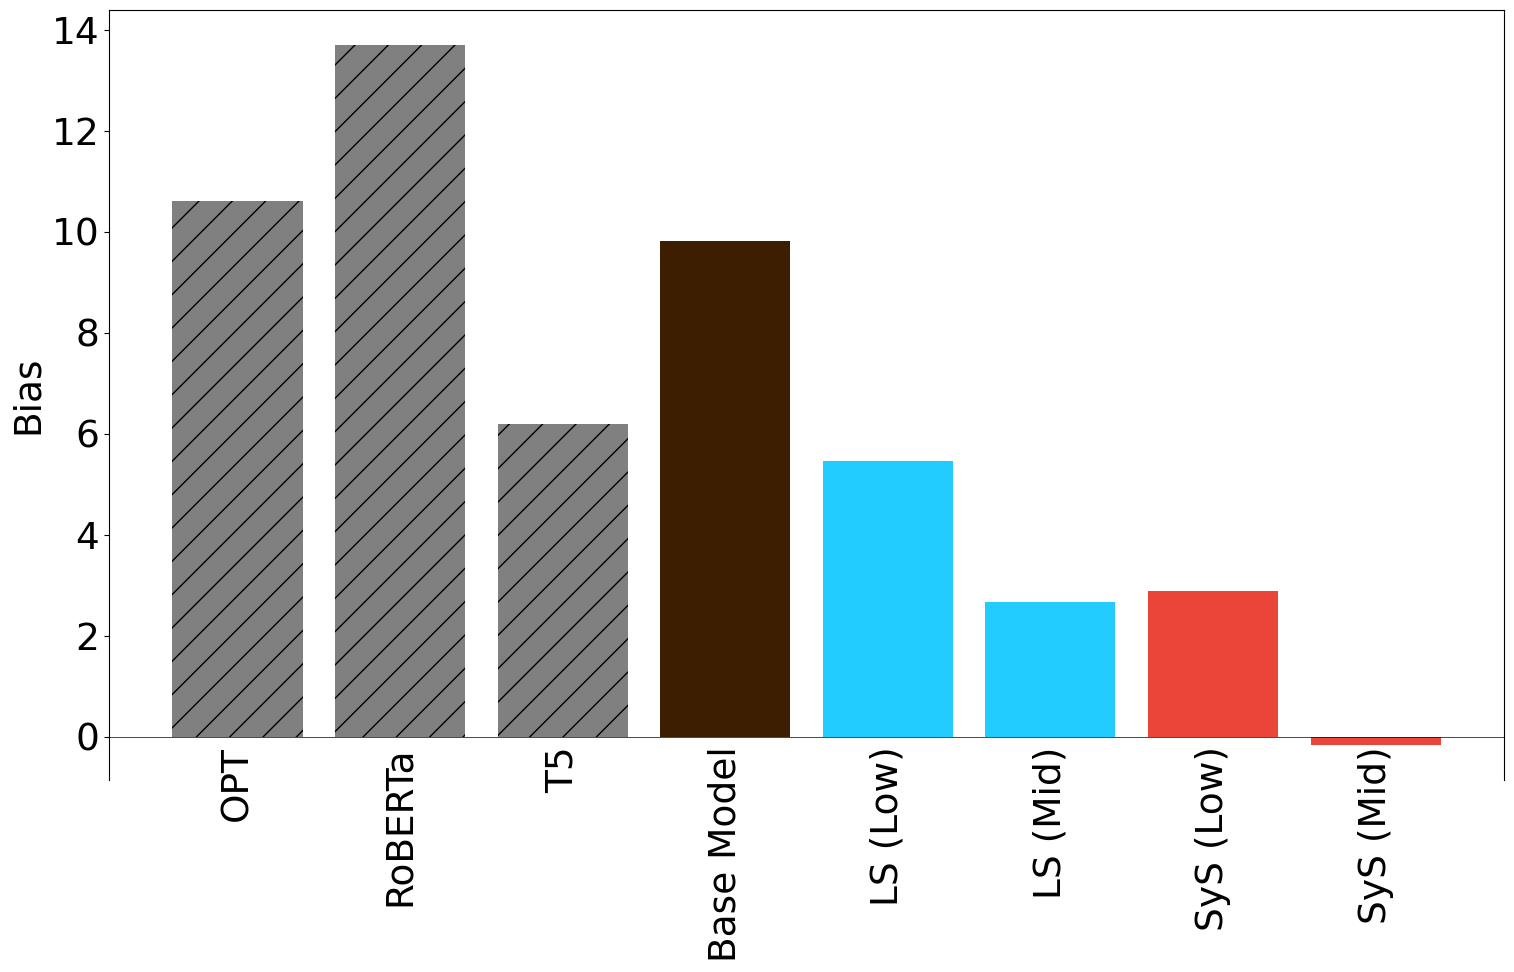

In [29]:
# Add gpt2 score to the bias results
baseline_biases = {
    'OPT' : 10.6,
    'RoBERTa' : 13.7,
    'T5' : 6.2,
}

new_ordered_model_names = ordered_model_names[0:5]

model_names = list(baseline_biases.keys()) + [model_name_conversion[model_name] for model_name in new_ordered_model_names]
mid_biases = [0] * 3 + [model_biases[model_name][4] for model_name in new_ordered_model_names]
biases = list(baseline_biases.values()) + [100*model_biases[model_name][-1] for model_name in new_ordered_model_names]
color = ['#808080'] * 3 + [line_colors[model_name] for model_name in new_ordered_model_names]

# Add hatch on first three
hatch = ['/', '/', '/'] + [None] * len(new_ordered_model_names)

# Plot bias as a bar chart
plt.figure(figsize=(18, 10))
plt.bar(model_names, biases, color=color, hatch=hatch)



plt.gca().spines['bottom'].set_position('zero')
plt.xticks(rotation=90)
# Shift x ticks up
plt.axhline(0, color='black', linewidth=0.5)
plt.gca().spines['bottom'].set_linewidth(0)
plt.tick_params(axis='x', which='both', bottom=False, top=False)
#plt.xlabel('Model')
plt.ylabel('Bias')
plt.show()